# Multimodal Search

In this final exercise, we will learn how to use vector databases to search through images using natural language. 

We will be searching through an open source image dataset using an open source model called CLIP.
This model is able to encode both images and text into the same embedding space, allowing us to retrieve images that are similar to a user question.

In [1]:
# pip install --quiet datasets gradio lancedb pandas transformers [This has been preinstalled for you]

## Setup CLIP model

First, let's prepare the [CLIP](https://huggingface.co/docs/transformers/model_doc/clip) model to encode the images.
We want to setup two things:
1. a model to encode the image
2. a processor to prepare the image to be encoded

Fill in the code below to initialize a pre-trained model and processor.

**SOLUTION** By reading the CLIP documentation, we see that we can use the `from_pretrained` classmethods to initialize the model and the processor

In [1]:
from transformers import CLIPModel, CLIPProcessor

MODEL_ID = "openai/clip-vit-base-patch32"

device = "cpu"

model = CLIPModel.from_pretrained(MODEL_ID).to(device)
processor = CLIPProcessor.from_pretrained(MODEL_ID)

/opt/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Setup data model

The dataset itself has an image field and an integer label.
We'll also need an embedding vector (CLIP produces 512D vectors) field.

For this problem, please a field named "vector" to the Image class below
that is a 512D vector.

The image that comes out of the raw dataset is a PIL image. So we'll add
some conversion code between PIL and bytes to make it easier for serde.

In [2]:
import io

from lancedb.pydantic import LanceModel, vector
import PIL

class Image(LanceModel):
    image: bytes
    label: int
    vector: vector(512)
        
    def to_pil(self):
        return PIL.Image.open(io.BytesIO(self.image))
    
    @classmethod
    def pil_to_bytes(cls, img) -> bytes:
        buf = io.BytesIO()
        img.save(buf, format="PNG")
        return buf.getvalue()

## Image processing function

Next we will implement a function to process batches of data from the dataset.
We will be using the `zh-plus/tiny-imagenet` dataset from huggingface datasets.
This dataset has an `image` and a `label` column.

For this problem, please fill in the code to extract the image embeddings from
the image using the CLIP model.

**SOLUTION** Here we'll use the `get_image_features` method on the model instance

In [3]:
def process_image(batch: dict) -> dict:
    image = processor(text=None, images=batch["image"], return_tensors="pt")[
        "pixel_values"
    ].to(device)
    img_emb = model.get_image_features(image)
    batch["vector"] = img_emb.cpu()
    batch["image_bytes"] = [Image.pil_to_bytes(img) for img in batch["image"]]
    return batch

## Table creation

Please create a LanceDB table called `image_search` to store the image, label, and vector.

**SOLUTION** this should be familiar to you by now. Let's call `lancedb.connect` then
`db.create_table`

In [4]:
import lancedb

db = lancedb.connect("~/.lancedb")
TABLE_NAME = "image_search"
db.drop_table(TABLE_NAME, ignore_missing=True)
table = db.create_table(TABLE_NAME, schema=Image.to_arrow_schema())

## Adding data

Now we're ready to process the images and generate embeddings.
Please write a function called `datagen` that calls `process_image` on each image in the validation set (10K images) and return a list of Image instances.

**HINT**
1. You may find it faster to use the [dataset.map](https://huggingface.co/docs/datasets/process#map) function.
2. You'll want to store the `image_bytes` field that is returned by `process_image`.

**SOLUTION**
1. We'll call `load_dataset` and retrieve the `valid` split
2. We then map `process_image` and construct Image instances

In [5]:
from datasets import load_dataset

def datagen() -> list[Image]:
    dataset = load_dataset("zh-plus/tiny-imagenet")['valid']
    return [Image(image=b["image_bytes"],
                  label=b["label"],
                  vector=b["vector"])
            for b in dataset.map(process_image, batched=True, batch_size=32)]

Now call the function you just wrote and add the generated instances to the LanceDB table. The following process can take up to 60 minutes to complete.

In [ ]:
data = datagen()


In [ ]:
table.add(data)

## Encoding user queries

We have image embeddings, but how do we generate the embeddings for the user query?
Furthermore, how can we possibly have the same features between the image embeddings
and text embeddings. This is where the power of CLIP comes in.

Please write a function to turn user query text into an embedding
in the same latent space as the images. 

**HINT** 
You can refer to the [CLIPModel documention](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPModel)

In [8]:
from transformers import CLIPTokenizerFast

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = CLIPTokenizerFast.from_pretrained(MODEL_ID)

def embed_func(query):
    inputs = tokenizer([query], padding=True, return_tensors="pt")
    text_features = model.get_text_features(**inputs)
    return text_features.detach().numpy()[0]

## Core search function

Now let's write the core search function `find_images`, that takes a text query as input, and returns a list of PIL images that's most similar to the query.

**SOLUTION**
First, we need to call `embed_func` on the query to generate the text embedding.
Then, we'll search through the LanceDB to get images most similar to the query.
And we'll convert the resrults into Image instances.
Finally, we'll call the `Image.to_pil` method to convert the bytes into PIL images

In [9]:
def find_images(query):
    emb = embed_func(query)
    rs = table.search(emb).limit(9).to_pydantic(Image)
    return [m.to_pil() for m in rs]

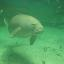

In [10]:
find_images("fish")[0]

## Create an App

Let's use gradio to create a small app to search through the images.
Please fill in the code below:
1. Create a [text input](https://www.gradio.app/docs/textbox) where the user can type in a query
2. Create a "Submit" [button](https://www.gradio.app/docs/button) that finds similar images to the input query and display the resulting images
3. A [Gallery component](https://www.gradio.app/docs/gallery) that displays the images


**SOLUTION**

1. The input is just `gr.Textbox` and you'll want to assign that to some variable
2. The submit button is `gr.Button`. Again, assign it to some variable
3. The gallery is `gr.Gallery`
4. You'll want to define the on click behavior for the button such that it uses
   the textbox value as input, calls the `find_images` function you wrote above,
   and uses the gallery to display the results

In [11]:
import gradio as gr


with gr.Blocks() as demo:
    with gr.Row():
        vector_query = gr.Textbox(value="fish", show_label=False)
        b1 = gr.Button("Submit")
    with gr.Row():
        gallery = gr.Gallery(
                label="Found images", show_label=False, elem_id="gallery"
            ).style(columns=[3], rows=[3], object_fit="contain", height="auto")   
        
    b1.click(find_images, inputs=vector_query, outputs=gallery)
    
demo.launch(server_name="0.0.0.0", inline=False)

/tmp/ipykernel_60/1501538491.py:9: GradioDeprecationWarning: The `style` method is deprecated. Please set these arguments in the constructor instead.
  gallery = gr.Gallery(


Running on local URL:  http://0.0.0.0:7860

To create a public link, set `share=True` in `launch()`.


To view the interface, click on the **Links** button at the bottom of the workspace window.  Then click on **gradio**.  This will open a new browser window with the interface.

Now try a bunch of different queries and see the results.
By default CLIP search results leave a lot of room for improvement. More advanced applications in this space can improve these results in a number ways like retraining the model with your own dataset, your own labels, and using image and text vectors to train the index. The details are however beyond the scope of this lesson.

## Summary

Congrats! 

Through this exercise, you learned how to use CLIP to generate image and text embeddings. You've mastered how to use vector databases to enable searching through images using natural language. And you even created a simple app to show off your work. 

Great job!